# **Food Classification and Calorie Estimation Project**

![Food Classification](https://upload.wikimedia.org/wikipedia/commons/thumb/6/6d/Good_Food_Display_-_NCI_Visuals_Online.jpg/640px-Good_Food_Display_-_NCI_Visuals_Online.jpg)

## Introduction

In the era of health-conscious living and technological advancements, the intersection of nutrition and artificial intelligence presents exciting opportunities. This project leverages deep learning techniques to tackle the challenge of food image classification and calorie estimation, aiming to provide a tool that can assist individuals in making informed dietary choices.

## Project Overview

This notebook demonstrates the development of a machine learning model capable of:
1. Classifying food images into distinct categories
2. Estimating the calorie content of the identified food items

## Dataset

We utilize a subset of the Food-101-tiny dataset, focusing on 10 diverse food categories. This curated dataset provides a balanced representation of various cuisines and food types, allowing our model to learn a wide range of visual features associated with different dishes.

## Technical Approach

1. **Data Preprocessing and Augmentation:**
   - We implement robust data preprocessing techniques to ensure our model receives consistent, high-quality input.
   - Data augmentation is employed to artificially expand our dataset, enhancing the model's ability to generalize.

2. **Model Architecture:**
   - We fine-tune the MobileNetV2 base and add custom dense layers to adapt it to our specific classification task.
   - The final layer uses softmax activation to output probabilities for each food category.

3. **Training and Evaluation:**
   - The model is trained using the Adam optimizer and categorical cross-entropy loss.
   - We implement early stopping to prevent overfitting and ensure optimal model performance.

4. **Calorie Estimation:**
   - Post-classification, we implement a calorie estimation feature based on average calorie content for each food category.



In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

print(tf.__version__)


2.17.0


## Data Preprocessing and Augmentation


In [4]:
# Define the dataset path
dataset_path = r'C:\Users\Hamad\Desktop\DataScience and AI 6 Months Mentorship\PRODIGY_ML\Prodigy_ML_05\data\food-101-tiny'

for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))


C:\Users\Hamad\Desktop\DataScience and AI 6 Months Mentorship\PRODIGY_ML\Prodigy_ML_05\data\food-101-tiny\train\apple_pie\1005649.jpg
C:\Users\Hamad\Desktop\DataScience and AI 6 Months Mentorship\PRODIGY_ML\Prodigy_ML_05\data\food-101-tiny\train\apple_pie\1014775.jpg
C:\Users\Hamad\Desktop\DataScience and AI 6 Months Mentorship\PRODIGY_ML\Prodigy_ML_05\data\food-101-tiny\train\apple_pie\1026328.jpg
C:\Users\Hamad\Desktop\DataScience and AI 6 Months Mentorship\PRODIGY_ML\Prodigy_ML_05\data\food-101-tiny\train\apple_pie\1028787.jpg
C:\Users\Hamad\Desktop\DataScience and AI 6 Months Mentorship\PRODIGY_ML\Prodigy_ML_05\data\food-101-tiny\train\apple_pie\1043283.jpg
C:\Users\Hamad\Desktop\DataScience and AI 6 Months Mentorship\PRODIGY_ML\Prodigy_ML_05\data\food-101-tiny\train\apple_pie\1050519.jpg
C:\Users\Hamad\Desktop\DataScience and AI 6 Months Mentorship\PRODIGY_ML\Prodigy_ML_05\data\food-101-tiny\train\apple_pie\1057749.jpg
C:\Users\Hamad\Desktop\DataScience and AI 6 Months Mentorship\

In [5]:
# Create a list with the filepaths for training and testing
train_dir = Path(os.path.join(dataset_path, 'train'))
train_filepaths = list(train_dir.glob(r'**/*.jpg'))


val_dir = Path(os.path.join(dataset_path, 'valid'))
val_filepaths = list(val_dir.glob(r'**/*.jpg'))


In [6]:
def image_processing(filepath):
    """Create a DataFrame with the filepath and the labels of the pictures"""
    labels = []
    for file in filepath:
        parts = os.path.normpath(file).split(os.sep)
        if len(parts) > 1:
            labels.append(parts[-2])
        else:
            labels.append("Unknown")

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df


In [7]:
train_df = image_processing(train_filepaths)
val_df = image_processing(val_filepaths)

In [8]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 1500

Number of different labels: 10

Labels: ['falafel' 'french_toast' 'apple_pie' 'ramen' 'sushi' 'ice_cream'
 'cannoli' 'edamame' 'tiramisu' 'bibimbap']


In [9]:
train_df.head(5)

,Filepath,Label
0,C:\Users\Hamad\Desktop\DataScience and AI 6 Mo...,falafel
1,C:\Users\Hamad\Desktop\DataScience and AI 6 Mo...,french_toast
2,C:\Users\Hamad\Desktop\DataScience and AI 6 Mo...,french_toast
3,C:\Users\Hamad\Desktop\DataScience and AI 6 Mo...,apple_pie
4,C:\Users\Hamad\Desktop\DataScience and AI 6 Mo...,ramen


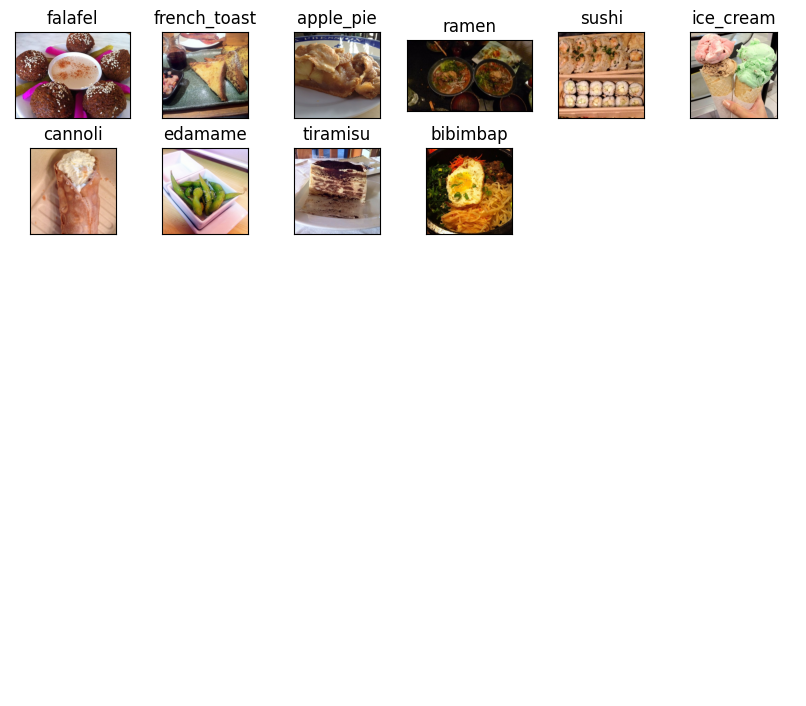

In [11]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    if i < len(df_unique):
        ax.imshow(plt.imread(df_unique.Filepath[i]))
        ax.set_title(df_unique.Label[i], fontsize=12)
    else:
        ax.axis('off')  # Turn off axis for empty subplots

plt.tight_layout(pad=0.5)
plt.show()

## Data Augmentation


In [12]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [13]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 1500 validated image filenames belonging to 10 classes.


In [14]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 500 validated image filenames belonging to 10 classes.


In [12]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 340 validated image filenames belonging to 36 classes.


## Model Architecture


In [15]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 9s 1us/step


## Training and Evaluation

In [17]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

# Get the number of classes from the training data
num_classes = len(train_images.class_indices)

outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5


c:\Users\Hamad\miniconda3\envs\python_ml\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4561 - loss: 1.6264 - val_accuracy: 0.7520 - val_loss: 0.7509
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.8571 - loss: 0.4795 - val_accuracy: 0.7960 - val_loss: 0.6098
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9207 - loss: 0.2951 - val_accuracy: 0.8240 - val_loss: 0.5542
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9588 - loss: 0.1612 - val_accuracy: 0.7920 - val_loss: 0.6275
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9782 - loss: 0.1080 - val_accuracy: 0.8020 - val_loss: 0.6779


In [19]:
# Predict the label of the test_images
pred = model.predict(val_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step


['bibimbap',
 'ice_cream',
 'ice_cream',
 'french_toast',
 'edamame',
 'ice_cream',
 'sushi',
 'ramen',
 'apple_pie',
 'bibimbap',
 'tiramisu',
 'bibimbap',
 'ice_cream',
 'ramen',
 'apple_pie',
 'ramen',
 'sushi',
 'sushi',
 'sushi',
 'tiramisu',
 'falafel',
 'falafel',
 'ice_cream',
 'tiramisu',
 'cannoli',
 'french_toast',
 'bibimbap',
 'falafel',
 'bibimbap',
 'tiramisu',
 'french_toast',
 'ice_cream',
 'edamame',
 'edamame',
 'tiramisu',
 'sushi',
 'bibimbap',
 'cannoli',
 'french_toast',
 'ice_cream',
 'edamame',
 'ice_cream',
 'tiramisu',
 'apple_pie',
 'sushi',
 'ice_cream',
 'bibimbap',
 'sushi',
 'ramen',
 'cannoli',
 'falafel',
 'sushi',
 'ramen',
 'french_toast',
 'apple_pie',
 'sushi',
 'sushi',
 'ice_cream',
 'apple_pie',
 'edamame',
 'ice_cream',
 'tiramisu',
 'tiramisu',
 'tiramisu',
 'ramen',
 'bibimbap',
 'french_toast',
 'cannoli',
 'edamame',
 'ramen',
 'edamame',
 'apple_pie',
 'cannoli',
 'cannoli',
 'edamame',
 'ice_cream',
 'sushi',
 'cannoli',
 'ramen',
 'sushi

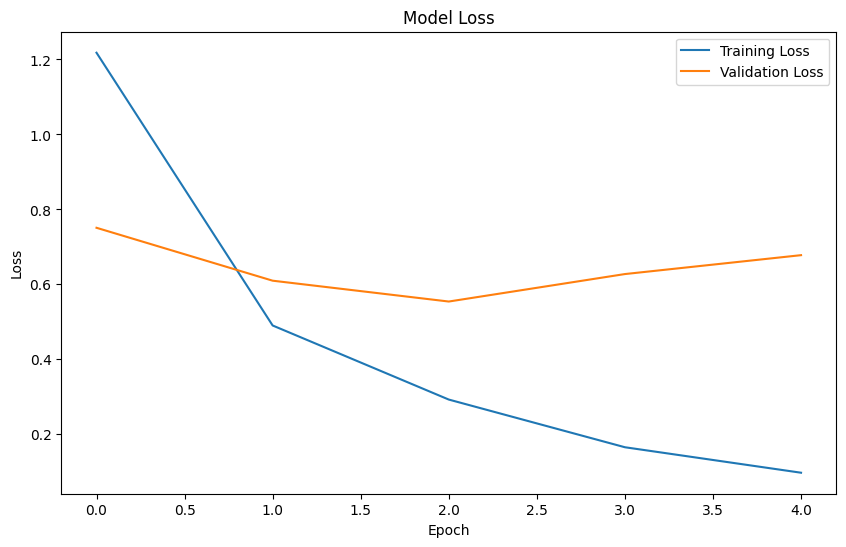

In [23]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


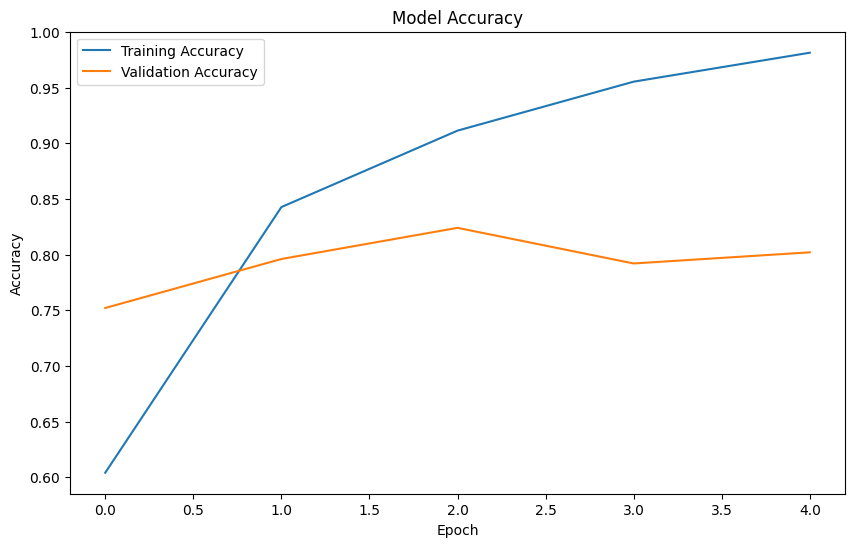

In [24]:
# Plot the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Calorie Estimation


In [31]:
def output(location):
    img = load_img(location, target_size=(224, 224, 3))
    img_array = img_to_array(img)
    img_array = img_array / 255
    img_array = np.expand_dims(img_array, [0])
    answer = model.predict(img_array)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    
    
    calorie_estimates = {
        'apple_pie': 237,
        'bibimbap': 560,
        'cannoli': 230,
        'edamame': 122,
        'falafel': 333,
        'french_toast': 229,
        'ice_cream': 207,
        'ramen': 380,
        'sushi': 300,
        'tiramisu': 240
    }
    estimated_calories = calorie_estimates.get(res, "Unknown")
    
    # Plot the predicted image with calorie estimation
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f'Predicted: {res}\nEstimated Calories: {estimated_calories}')
    plt.axis('off')
    plt.show()
    
    return res, estimated_calories

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


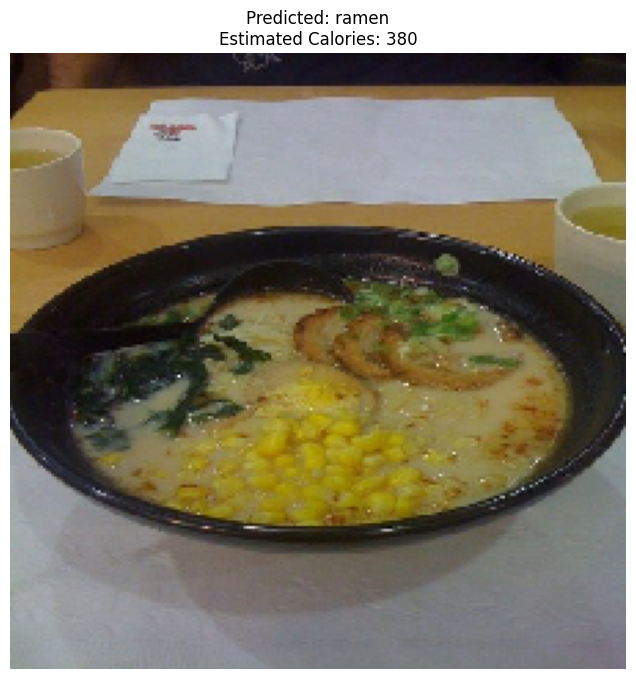

In [32]:
img = output(r'C:\Users\Hamad\Desktop\DataScience and AI 6 Months Mentorship\PRODIGY_ML\Prodigy_ML_05\data\food-101-tiny\valid\ramen\12611.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


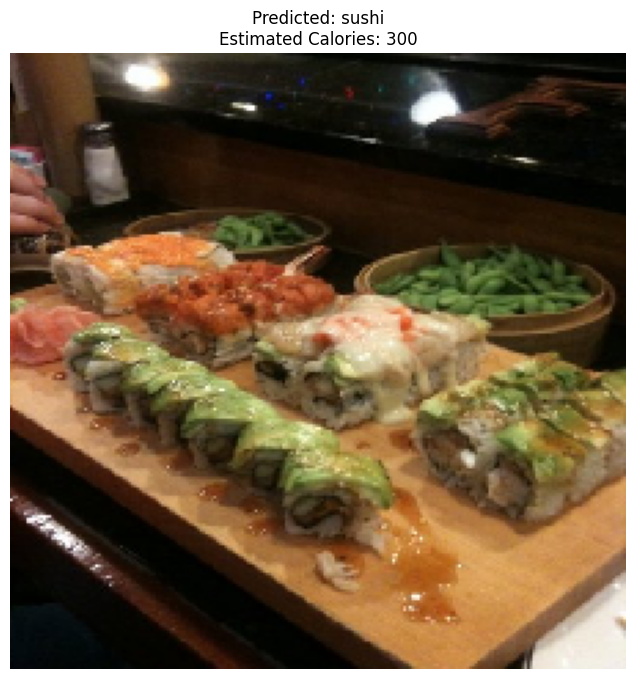

In [34]:
img =  output(r'C:\Users\Hamad\Desktop\DataScience and AI 6 Months Mentorship\PRODIGY_ML\Prodigy_ML_05\data\food-101-tiny\valid\sushi\101625.jpg')